<a href="https://www.nvidia.com/dli"> <img src="img/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Transforming How We Diagnose Heart Disease


Cardiovascular disease, also commonly referred to as heart disease, takes on many forms - heart attacks, stroke, heart failure and arrhythmia - to name a few.  According to a report published on behalf of the American Heart Association, 610,000 Americans die each year from heart disease.

Booz | Allen | Hamilton and Kaggle offered the [2015 Data Science Bowl](https://www.kaggle.com/c/second-annual-data-science-bowl) as an opportunity for data scientist to help automate the diagnosis of heart disease through a competition.  

Two indicators of the presense of heart disease are "volumes" (both end-systolic and end-diastolic) and the "ejection fraction" (EF). Part of the initial overview of the challenge included the following image:

![alt text](img/fig2.jpg "Only One Unit of Time That Matters")

End-systolic and end-diastolic volumes yield the ejection fraction (EF) noted above in the image and represented below in the formula where $V_S$ denotes the volumes at systole and $V_D$ denotes the volumes at diastole.  

$$100\cdot\frac{V_D-V_S}{V_D}$$  

In addition, Magnetic Resonance Imaging (MRI) correctly assess the heart's squeezing ability.  However, evaluation of MRIs is a manual, time consuming process - deep neural networks can automate this process.  Variations in anatomy, function, image quality, and acquisition make automated quantification of left ventricle size a challenging problem. You will encounter this variation in the competition dataset, which aims to provide a diverse representation of cases. 

<img src="img/fig8.png" alt="Manual determination of ejection fraction" style="width: 700px;"/>
<p style="text-align: center;">*C.M.S Nambakhsh et al., Medical Image Analysis 17(2013) 1010-1024*</p>


## The Dataset
The National Heart, Lung, and Blood Institute (NHLBI) provided the MRI images for the Data Science Bowl. The [dataset](https://www.kaggle.com/c/second-annual-data-science-bowl/data) consists of hundreds of cardiac MRI images in [DICOM](https://en.wikipedia.org/wiki/DICOM) format. These 2D cine images contain approximately 30 images across the cardiac cycle. Each slice is acquired on a separate breath hold. This is important since the registration from slice to slice is expected to be imperfect.


<img src="img/fig3.gif" alt="MRI imaging of heartbeat" style="width: 500px;"/>

The dataset contains patients from young to old, images from numerous hospitals, and hearts from normal to abnormal cardiac function. A computational method which is robust to these variations could both validate and automate the cardiologists' manual measurement of ejection fraction.  Each case has an associated directory of DICOM files. The exact number of images will differ from case to case, either varying in the number of slices, the views which are captured, or the number of frames in the time sequences.

The main view for assessing ventricle size is the short axis stack (PSAX), which contains images taken in a plane perpendicular to the long axis (PLAX) of the left ventricle: 

<img src="img/fig6.png" alt="PSAX diagram" style="width: 250px;"/>
<p style="text-align: center;">*image credit: fpnotebook.com*</p>

These have the prefix "sax_" in the dataset. Most cases also have alternative views.

## Evaluation
Performance is evaluated using the Continuous Ranked Probability Score (CRPS). For each MRI, a cumulative probability distribution is predicted for both the systolic and diastolic volumes (two separate distributions per case). The CRPS is computed as follows:

$$CRPS = \frac{1}{600\cdot N}\sum_{m=1}^{N}\sum_{n=0}^{599} (P(y\le n)-H(n-V_{m}))^2$$

where $P$ is the predicted distribution, $N$ is the number of rows in the test set (equal to twice the number of cases), $V$ is the actual volume (in mL) and $H(x)$ is the Heaviside step function ($H(x\lt0)=0$ and $H(x\ge 0)=1$).  While it is not simple to visualize the CRPS, the shaded area on the figure below may be a helpful guide for understanding the error term between the predicted distribution and actual volume:
<img src="img/fig4.png" alt="CRPS error between predicted and actual volume" style="width: 500px;"/>
Note that the entry will not score if any of the predicted values has $P(y \le k) > P(y \le k+1)$ for any $k$.  That is the CDF is non-decreasing.

# End-to-End Deep Learning for NDSB-II

In this example, we will show how to use GPU accelerated MXNet library to build an end-to-end deep learning system to help diagnose heart disease.  Keep in mind, this is a very simple model without any network structure optimizations or hyper parameter tuning.  However, it is possible to build fantastic networks based on the example solution.

### About MXNet
[MXNet](https://github.com/dmlc/mxnet) is a deep learning framework designed for both efficiency and flexibility by DMLC group. MXNet will fully utilize all the resources to solve the problem under limited resource constraint, with a flexible programming interface. You can use it for all purposes of data science and deep learning tasks with R, Julia, Python and more. To run on multiple GPU with huge network, or questions about saving network parameters etc, please refer [MXNet docs](https://mxnet.readthedocs.org/en/latest/)

## General Overview of Model
### Input Data
The dataset itself contains 500 training studies with on average 10 unique SAX observation at various points along the the PLAX of the left ventricle.  That’s roughly 5000 observations in total.  Each of these SAX observation usually contain 30 DICOM images (“frames”) in a time sequence which captures an entire heartbeat (expansion and contraction).   The idea here is to pack each of the 30 image frames of an observation into a 64x64x30 tensor.  While this might sound complicated, just think of stacking playing cards to form a deck.  Each card has the same rectangular dimensions (say, 120x90) and then cards are stacked one on top of the other to form a deck.  It’s the same thing here.  We’re going to take each of the 30 square image frames of 64x64 pixels and stack them one-by-one to form an input “deck” to the deep neural network.  The only difference with the card deck analogy is that the image frames are organized in time so that the video clip of the heartbeat is not all garbled.  This tutorial is based on this simple idea: we first accumulate all suitable observations having 30 frames, then feed to the deep neural network to learn the target directly.

The label data set contains only 500 labels. That is, each of the roughly 10 SAX observation for a particular study get the same diastole and systole volume.  Again, each SAX observation of a study is just a different view of the same heart (i.e. a single heartbeat as measured from different cross sections perpendicular to the long axis of the heart).  Therefore, in the data preprocessing step, each label must be duplicated for each unique observation.

Additionally, the same 64x64x30 deck of images is used to predict both systole and diastole volumes.  Therefore, we’re going to build a network that ingests each observation tensor to predict systole volume.  Then a separate network that ingests that same image deck to predict diastole volume.

Another idea used in this tutorial is taking a frame-by-frame difference to measure change per frame (in time).  By using MXNet symbolic interface, we can dynamically difference the input inside of the network. It helps a little in the final result.

### Network Objective
For the network, we use the well documented LeNet style convolution network with batch normalization and dropout. This is a basic network with a generic configuration.  In this challenge, we are asked to predict a CDF value of 600 data-point. Therefore the problem is formulated as a regression problem. We ask the neural-net that given a stack of images 64x64x30 to output 600x1 vector - one predicted value for each of the 600 points in the CDF.  Note here that the label is just a single floating point value like 83.3 (mL).  This label is transformed into a step function having 600 discrete values where all the y-values of the CDF with x less than 83 are 0 and all y-values with x greater than 83 are 1.


### Preprocessing
We first run a preprocessing step, to pack the data into a csv file (```train-64x64-data.csv```).  Each line of this csv file corresponds to a 64 x 64 x 30 tensor, which gives 30 frames of images. We can also use other inputs besides csv. The CSV is used here since this format is common for all languages and is easy to parse.

The input dataset is quite big (5293 observations of size 64x64x30). While this data set can likely fit into memory of a big machine, we want to be safe, so we will use the ```CSVIter``` from ```mxnet``` to load data from disk on-the-fly during training, without loading all the data into memory at once.

The labels for the training data are stored in ```train-systole.csv``` and ```train-diastole.csv``` where each line is a step function of 0s and 1s as described above. Line ```i``` in the training CSV data file is label by the associated line ```i``` in the label CSV files.  Again, when training the systole network we will use labels from ```train-systole.csv``` and likewise when training the diastole network we will use labels from ```train-diastole.csv```.




## Code

First we load the necessary libraries

In [1]:
# import libraries
require(mxnet)
require(data.table)
require(ggplot2)

Loading required package: mxnet
Loading required package: data.table
Loading required package: ggplot2


Next we define a function that will architect (not trained yet) neural networks.  This network is a classic network that has it's origins from Yann LeCun's paper many years ago and hence has the nostalgic name "LeNet".  

Notice here that we create a variable using ```mx.symbol.Variable``` which *represents* the input data.  Just like regular variables we can manipulate the ```source``` variable.  For example, the first thing we do to the image data input is to normalize the pixel values. Next we utilize ```mx.symbol.SliceChannel``` so that we can actually access each individual frame of the input.  Recall that the input is 64x64x30 so that each indexed frame is of size 64x64. The purpose of using the frames is so that differences between successive frames can be calculated. That is, instead of training the network parameters using the images directly, the network is trained on the differences between each successive frame.  This is pretty cool since we can actually manipulate the data within the network definition rather than having to preprocess the whole dataset when we want to experiment with a new idea.  Once each frame delta has been computed the individual frames are put back into a 64x64x29 tensor input using ```mxnet:::mx.varg.symbol.Concat```.  Since we've taken successive deltas we actually only have 29 total deltas now!  

From here we just chain various layers together, such as ```mx.symbol.Convolution```, to form the network described in LeCun's paper.  There is no magic here.  Feel free to add layers in between or remove layers etc.  That's part of the fun of working with DL; various recipies have been described in papers over the years but you're free to construct anything you'd like.  Play with the network structure to get a feel for how training performance changes. 



In [2]:
# Create LeNet style network
get.lenet <- function() {
    
    # create data variable (i.e. symbol)
    source <- mx.symbol.Variable("data")
    
    # normalize values of input data 
    source <- (source-128) / 128
    
    # SliceChannel is a symbol that can be indexed just like an array
    frames <- mx.symbol.SliceChannel(source, num.outputs = 30);
    
    # init list of differences
    diffs <- list()
  
    # compute differences for each "frame"
    for (i in 1:29) {
        diffs <- c(diffs, frames[[i + 1]] - frames[[i]])
    }
  
    # set the property for number of arugments in diffs variable
    diffs$num.args = 29
    
    # concatonate frame variables into single variable
    source <- mxnet:::mx.varg.symbol.Concat(diffs)
    
    # convolution layer with 5x5 kernel dimention
    net <- mx.symbol.Convolution(source, kernel = c(5, 5), num.filter = 40)
    
    # normalization layer: simply subtract mean divide by std
    net <- mx.symbol.BatchNorm(net, fix.gamma = TRUE)
    
    # activation layer using Rectified Linear Unit (relu) activation function
    net <- mx.symbol.Activation(net, act.type = "relu")
    
    # Max pooling layer with a 2x2 kernel and no overlap since stride is 2x2
    net <- mx.symbol.Pooling(net, pool.type = "max", kernel = c(2, 2), stride = c(2, 2))
    
    # continue building the network ...
    net <- mx.symbol.Convolution(net, kernel = c(3, 3), num.filter = 40)
    net <- mx.symbol.BatchNorm(net, fix.gamma = TRUE)
    net <- mx.symbol.Activation(net, act.type = "relu")
    net <- mx.symbol.Pooling(net, pool.type = "max", kernel = c(2, 2), stride = c(2, 2))
    
    # flatten the features to single variable
    flatten <- mx.symbol.Flatten(net)
    
    # add a drop out layer where 50% of data gets dropped out at training time
    flatten <- mx.symbol.Dropout(flatten)
    
    # add the final fully connected layer for output of dimension 600
    fc1 <- mx.symbol.FullyConnected(data = flatten, num.hidden = 600)
    
    # Name the final layer as softmax so it auto matches the naming of data iterator
    # Otherwise we can also change the provide_data in the data iter
    return(mx.symbol.LogisticRegressionOutput(data = fc1, name = 'softmax'))
}

If you want to know more about a particular layer, pull up the help listing for that layer. For example,?mx.symbol.Activation provides the help information for the activation layer where additional functions are listed for use such as 'sigmoid', 'tanh' and so on.

In [3]:
?mx.symbol.Activation

Next the training batch size is specified.  The size can be smaller or larger arbitrarily but since we're using GPUs for the training we have to be careful not to use a really large batch size since the GPU has limited memory.  The batch size is also a factor of how large the input images are.  Since each input is a 64x64x30 tensor, 16 is a good size. It is not the end of the world if batch size is too large.  If the batch size is too large, the training command will just fail and complain about something like "device out of memory" which is likely your queue to reduce the batch size.

In [4]:
batch_size <- 16

Next we load the training data using an iterator so that we use host memory efficiently.  This is nice since it does not consume huge amounts of data but the trade off is that it does increase the training time since we have to keep loading data over and over. 

In [5]:
# CSVIter is used here, since the data can't fit into memory
data_train <- mx.io.CSVIter(
   data.csv  = "./train-64x64-data.csv", data.shape  = c(64, 64, 30),
  label.csv  = "./train-systole.csv"   , label.shape = 600,
  batch.size = batch_size
)

Lets now initialize a LeNet style network using our network function.  This network has structure but none of the parameters are determined yet.  Think of it as raw materials that will be shaped into meaningful values/parameters during the training phase.  Notice that when this function is called all of the parameters are initialized to random values which does actually consume memory on the system.  If the network has 10 million parameters in it then we have to initialize 10 million values in memory.  Also, all the network parameters must actually fit into the GPU memory (with the input data too!) so if the network structure is too large then it is possible to run out of memory on the GPU.  So, start conservatively and grow the network as you work through the performance requirements. 

In [7]:
network <- get.lenet()
network

C++ object <0x4c7cc00> of class 'MXSymbol' <0x4b905b0>

Before we can train the network parameters we must specify a *loss function* also called a *cost function*.  This function tells the training algoritm how closely the current set of parameters reproduce the target output.  In general, for a given cost function the training algorithm will try to choose parameters for which the cost function is minimized.  That is, a lower cost is better than higher cost. 

In [8]:
# Custom evaluation metric using CRPS.
costfun <- function(label, pred) {
  pred  <- as.array(pred )
  label <- as.array(label)
  return(sum((label - pred) ^ 2) / length(label))
}

# create custom mxnet metric for training
mx.metric.CRPS <- mx.metric.custom("CRPS", costfun)

Now you are ready to train your architected network with training data to build a model.  Below we offer two options - use our pretrained model provided in the first code block below that was created with 65 training rounds (epochs) or train your own model in the second code block below using a smaller number of training rounds (five training rounds will likely take 10+ minutes to execute).  Once you feel comfortable, feel free to experiment with the learning rate, momentum etc. and see how the training performance changes.

NOTE: No changes are needed in the first of two code blocks that follow this explanation and you only need to execute one of the two code blocks.

Notice that one of the arguments provided is ```ctx = mx.gpu(0)``` which effectively tells MXNet to use GPU with device id equal to 0.  If you want to perform the training with the CPU instead then set the context to ```ctx=mx.cpu()```.  Furthermore, an array of GPU devices can be passed into the context for multi-gpu training if there are more than one GPU devices present on the machine.  Keep in mind here that using multiple GPU devices for training incurs some overhead - especially with large datasets.  It's not unusual that training time actually increases when using multiple GPU due to the additional data transfer required. So definitely start small and grow the training strategy and always profile execution times etc. to keep an eye on learning performance. 

If you want to save some time, simply load the pretrained model using the cell below and skip the cell that follows.

In [9]:
# load the pretrained result
systole_model <- mx.model.load("stytole_model_BN",65)

Execute the cell above if you would like to use the pretrained results OR execute the code below if you would like to train the model yourself.

In [10]:
# Training the systole model (this takes a long time).

# set the random seed so the results are reproducible
mx.set.seed(0)

# start the clock
start_time <- proc.time()

# train the model parameters with the data
systole_model <- mx.model.FeedForward.create(
  X             = data_train,
  ctx           = mx.gpu(0) ,
  symbol        = network   ,
  num.round     = 5         ,
  learning.rate = 0.01      ,
  wd            = 0.0001    ,
  momentum      = 0.9       ,
  eval.metric   = mx.metric.CRPS
)

# get the time delta
proc.time() - start_time

Start training with 1 devices
[1] Train-CRPS=0.0481668175688349
[2] Train-CRPS=0.0343573634394582
[3] Train-CRPS=0.033205289829941
[4] Train-CRPS=0.032136443729039
[5] Train-CRPS=0.0310192129196943


   user  system elapsed 
182.556  16.500 336.316 

If you've trained a network and want to save the results then export the trained model so it can be reloaded without having to perform training phase next time

In [11]:
# Save the trained neural network model to disk.
# This creates two files: 
#    1. systole_model-0005.params
#    2. systol_model-symbol.json
#
# WARNING: the 5 here must match num.rounds parameter provided to mx.model.FeedForward.create
#          So if the model was saved at 5, then it must be loaded with 5.
#
mx.model.save(systole_model,"systole_model_BN",5)

Just to get a better feel for the data, lets extract it using the CSV iterator.  Doing this reads in the entire dataset in to host memory.  This can be prohibative with a large dataset.  

In [12]:
# this reads in all the data at once (not a great idea, but we can do it)
labels <- mx.io.extract(data_train,"label")
data   <- mx.io.extract(data_train,"data" )

Once the data has been loaded we can check the dimensions.  As advertised we have ~ 5000 training samples each of size 64x64x30.

In [13]:
# 
dim(labels)
dim(data)

[1]  600 5293

[1]   64   64   30 5293

Using the trained model we can pass input samples into the model to predict their systolic volume.  To select various samples we index into the data variable ```data[,,,1:20]``` to extract some samples. Notice here we're selecting input data along the 4th dimension.  That is we're selecting ```N``` input samples with dimension 64x64x30 and by leaving the first three index empty we are effectively saying "give me everything" along that dimension.

In [14]:
# create index for selecting samples
sample_index = c(1:20);

# apply the model to just a few data to generate some predictions
model_predictions <- predict(systole_model, data[,,,sample_index])

Now lets have a look at what was predicted by the model for these input.  Try selecting a different index for the plot to view other predictions and their label.  Don't hesitate to predict more input in the cell above to investigate even further.

[1] 0.02482318

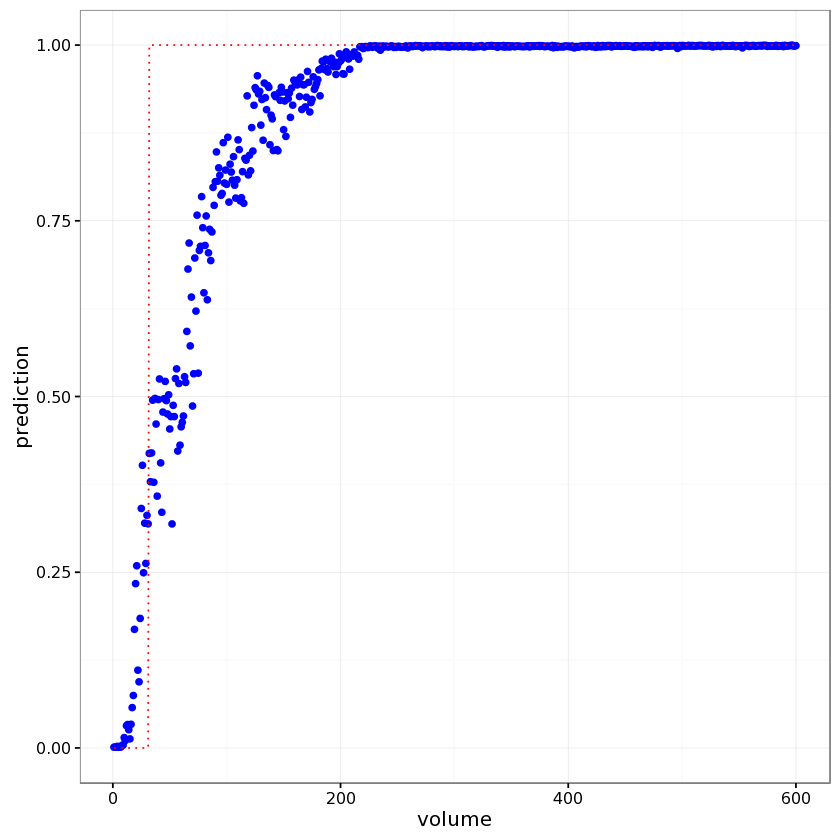

In [15]:
# have a look at what the label and associated prediction looks like
ix = 14;
x  <- seq(1, 600, 1)
y1 <- model_predictions[,ix]
y2 <- labels[,ix]
df <- data.frame(volume=x,prediction=y1,label=y2)

# basic graphical object
ggplot(df, aes(volume)) +
  
  # the predicted CDF using the trained model
  geom_point(aes(y=prediction), color="blue") +  

  # the label for this set of images (i.e. systole volume)
  geom_line(aes(y=label), color="red", linetype="dotted") + 

  # make the plot theme simple 
  theme_bw()

# evaluate the cost function for this prediction
costfun(labels[,ix],model_predictions[,ix])

Notice how the prediction (blue curve) is a logistic like curve (CDF) while the label is a step function.  Certainly we can use our cost function to get a sense for how "close" the set of predictions are to their labels.  However, notice with this formulation of the problem it's not very easy to look at the prediction and call out what the actual volume predicted is.  

In [16]:
costfun(labels[,sample_index],model_predictions[,sample_index])

[1] 0.02606552

## OK Now it is your Turn!

Lets use what we've learned from creating the ```systole_network``` and create a network to predict diastole volume.

Step 1. Create a training data set using the diastole labels 

Step 2. Create network 

Step 3. Train the network


In [19]:
# step 1
# CSVIter is used here, since the data can't fit into memory
data_train_diastole <- mx.io.CSVIter(
   data.csv  = "./train-64x64-data.csv", data.shape  = c(64, 64, 30),
  label.csv  = "./train-diastole.csv"   , label.shape = 600,
  batch.size = batch_size
)
data_train_diastole

C++ object <0x1b2f7fd0> of class 'MXNativeDataIter' <0x4ba5ff0>

In [21]:
# step 2
network_diastole <- get.lenet()
print(network_diastole)

# set the random seed so the results are reproducible
mx.set.seed(0)

# start the clock
start_time <- proc.time()

# train the model parameters with the data
diastole_model <- mx.model.FeedForward.create(
  X             = data_train_diastole,
  ctx           = mx.gpu(0) ,
  symbol        = network_diastole,
  num.round     = 5         ,
  learning.rate = 0.01      ,
  wd            = 0.0001    ,
  momentum      = 0.9       ,
  eval.metric   = mx.metric.CRPS
)

# get the time delta
proc.time() - start_time

C++ object <0x219ad950> of class 'MXSymbol' <0x4b905b0>
Start training with 1 devices
[1] Train-CRPS=0.0652898599732858
[2] Train-CRPS=0.0512829253625502
[3] Train-CRPS=0.0493174068008693
[4] Train-CRPS=0.0475295476931218
[5] Train-CRPS=0.0456691814859295


   user  system elapsed 
106.456  15.600  54.561 

In [22]:
# step 3
# this reads in all the data at once (not a great idea, but we can do it)
labels_diastole <- mx.io.extract(data_train_diastole,"label")
data_diastole   <- mx.io.extract(data_train_diastole,"data" )

In [23]:
# apply the model to just a few data to generate some predictions
model_predictions_diastole <- predict(diastole_model, data_diastole[,,,sample_index])

[1] 0.07180632

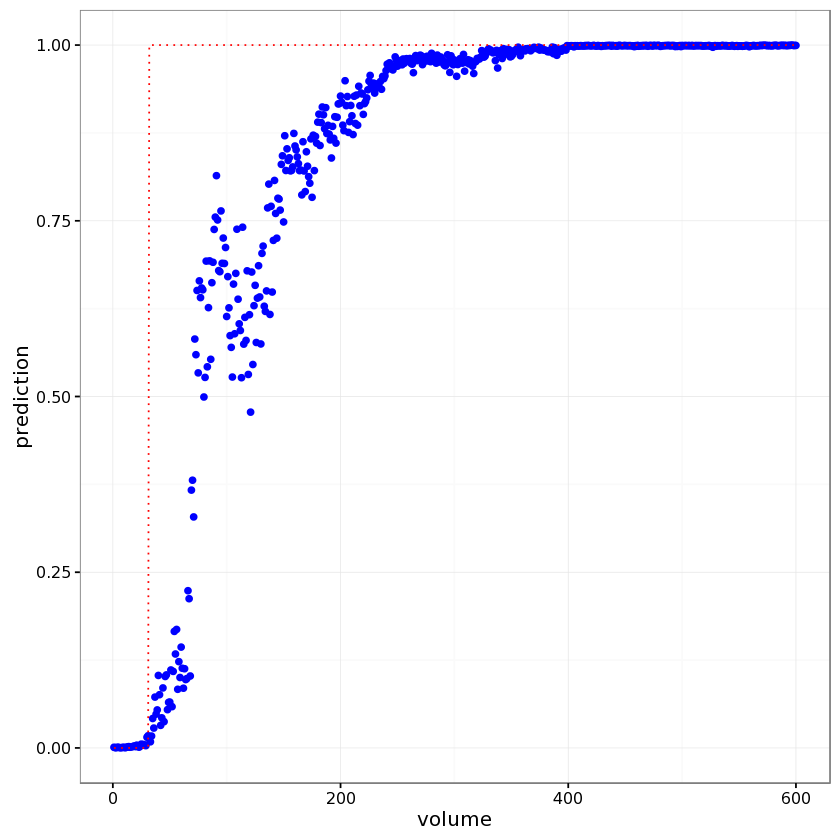

In [24]:
# have a look at what the label and associated prediction looks like
ix = 14;
x  <- seq(1, 600, 1)
y1 <- model_predictions_diastole[,ix]
y2 <- labels[,ix]
df <- data.frame(volume=x,prediction=y1,label=y2)

# basic graphical object
ggplot(df, aes(volume)) +
  
  # the predicted CDF using the trained model
  geom_point(aes(y=prediction), color="blue") +  

  # the label for this set of images (i.e. systole volume)
  geom_line(aes(y=label), color="red", linetype="dotted") + 

  # make the plot theme simple 
  theme_bw()

# evaluate the cost function for this prediction
costfun(labels[,ix],model_predictions_diastole[,ix])

In [25]:
costfun(labels_diastole[,sample_index],model_predictions_diastole[,sample_index])

[1] 0.05038211

## Discovery Requires Experimentation ...

There are many ways to explore and even improve this model:

1. Maybe try removing batch normalization layers ([ref](https://arxiv.org/abs/1502.03167)) [hint: modify get.lenet()]
2. Try increasing or decreasing the number of features in the convolution layer [hint: modify ```num.filter``` in get.lenet()]
3. How does batch size effect training?
4. Have a go at modifying the learning rate and momentum of the training phase [hint: learning.rate, wd, and momentum]
5. Notice that the CRPS function uses the residual squared.  What else might we try (hint: try abs in costfun)
6. Try using different activation functions (i.e. other than relu).  How does this effect performance?
7. Maybe try using different pooling functions (i.e. other than max) [hint: use help to see other functions]
8. Maybe try removing dropout layer or modifying the percentage dropout (i.e. default is 50%)
9. Maybe try double differencing the data or not differencing the data at all
10. What are other ways we could formulate the network output (i.e. other than discrete CDF)?

# NDSB Competition Results

There were nearly [200 participants](https://www.kaggle.com/c/second-annual-data-science-bowl/leaderboard) in the NDSB-II with a variety of different approaches to solving this challange. The CRPS scores for the leaderboard top ten ranged from 0.009485 in first place to 0.012611 in tenth place.  To get a better feel for how your results stackup against the competion, we created an empirical CDF from the leaderboard CRPS scores:
<img src="img/fig10.png" alt="CRPS ECDF" style="width: 500px;"/>
Therefore, achieving a CRPS score of 0.03 is at about the 80th percentile w.r.t. the overall competition results.  

So how much better is a CRPS of 0.009485 than 0.012611?  To get a loose sense for how CRPS effects ejection fraction calculations, the competition provided this infographic to performers:

<img src="img/fig11.png" alt="CRPS ECDF" style="width: 700px;"/>

Analysis of the competition results seem more favorable than this graphic might imply and noted that top performer models agreed well with previous studies of human performance.  For a medical perspective on the competion results check out this [kaggle blog](https://www.kaggle.com/c/second-annual-data-science-bowl/forums/t/19839/a-medical-perspective-on-the-quality-of-the-left-ventricular-volume-and) by Dr. Andrew Arai of the NIH.  Additional analysis of the clinical applicability provided by Jonathan Mulholland of Booze Allen Hamilton [here](http://www.datasciencebowl.com/leading-and-winning-team-submissions-analysis/). These analysis conclude, based on the top four models submitted to the competion, that "*The models keep the diagnosis categories pretty tightly grouped together. While the models are not right 100% the time, there is a very low probability of a severely abnormal EF being incorrectly categorized in the mild to hyperdynamic range. The normal to mild diagnoses are very likely to stay within their domain ... This is a pretty good sign pointing towards suitability for clinical applications*".